In [54]:
#libraries for loading and manipulating data.
import numpy as np
import pandas as pd

#libraries for NLP and text preprocessing
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
import string 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#libraries for visualisation 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

#libraries for modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

#libraries for score metrics
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# set plot style
sns.set()

## Loading Data

In [2]:
#load data
df_train = pd.read_csv('train.csv')

train_set = df_train.copy()

pd.set_option('max_colwidth', None)
train_set.head()

,sentiment,message,tweetid
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221
1,1,It's not like we lack evidence of anthropogenic global warming,126103
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954


## EDA
* Shape of the data
* Check if there are any null entries 
* Distinct sentiment types and frequency of each in dataset (bar graph representation)
* Duplicate entries (tweetid)
* Most common words before data cleaning (word cloud)

In [3]:
# General eda 
def eda (df):
    shape = train_set.shape
    null_entries = train_set.isnull().sum()
    dist_sent = list(train_set.sentiment.unique())
    duplicate = df.columns.duplicated().any()
    
    # summary
    a = print ('Shape of dataframe is ' + str(shape[0]) + ' rows and ' + str(shape[1]) + ' columns')
    b = print ('Unique sentiemnts are: ' +  str(dist_sent))
    c = print ('Duplicate entries: ', duplicate)
    d = print ('Checking for null entries in each column:\n' ,null_entries)
    
    return a,b,c,d

eda(train_set)

Shape of dataframe is 15819 rows and 3 columns
Unique sentiemnts are: [1, 2, 0, -1]
Duplicate entries:  False
Checking for null entries in each column:
 sentiment    0
message      0
tweetid      0
dtype: int64


(None, None, None, None)

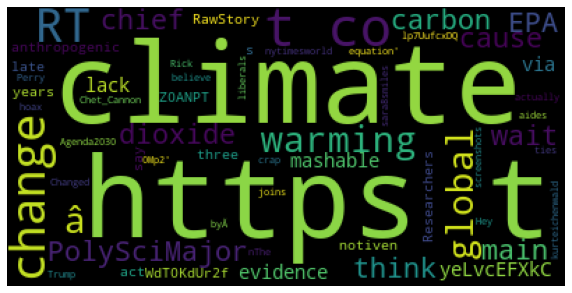

In [4]:
#Graphical EDA (wordcloud)
def word_cloud (df, column_name):
    wc = WordCloud()
    text = df[column_name].values
    msg_cloud = wc.generate(str(text))
    
    #plot wordcloud
    fig,ax = plt.subplots(figsize=(10,10))
    ax.plot
    plt.imshow(msg_cloud)
    plt.axis('off')
    plt.show
    
    return wc

word_cloud(train_set, 'message')

Word cloud summary:
* There are a lot or url links in the text (https)
* Frequently used specific words RELEVANT to climate change are: climate, global, warming, change, EPA( United States Environmental Protection Agency, dioxide, RT(a news network), CO (carbon monoxide), mashable(a news network), think, cause, change, evidence 

C:\Users\Stella\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Percentage of Sentiments')

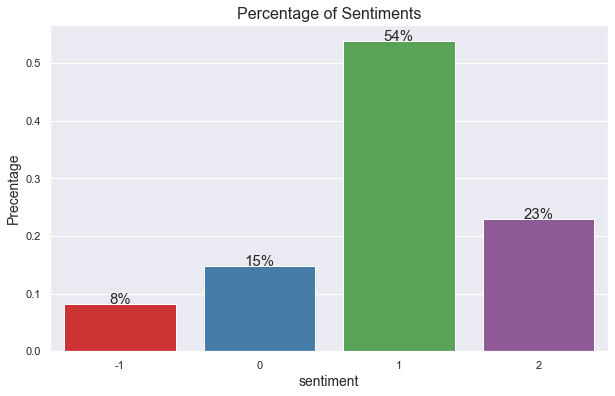

In [20]:
#How many data samples are provided for each sentiment
plt.figure(figsize=(10,6))
g = sns.barplot(train_set['sentiment'], train_set['sentiment'], palette='Set1', estimator=lambda x: len(x) / len(train_set))

for p in g.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    g.text(x+width/2, 
           y+height, 
           '{:.0%}'.format(height), 
           horizontalalignment='center',fontsize=15)
    
#Setting the labels
plt.xlabel('sentiment', fontsize=14)
plt.ylabel('Precentage', fontsize=14)
plt.title('Percentage of Sentiments', fontsize=16)

### Class Imbalance

In [ ]:
#deal with class imbalance

In [21]:
#Percentage of each sentiment in the dataset
#print("1 Pro: ", train_set.sentiment.value_counts()[1]/len(train_set)*100,"%")
#print("2 News: ", train_set.sentiment.value_counts()[2]/len(train_set)*100,"%")
#print("0 Neutral: ", train_set.sentiment.value_counts()[0]/len(train_set)*100,"%")
#print("-1 Anti: ", train_set.sentiment.value_counts()[-1]/len(train_set)*100,"%")

In [22]:
#Graphical EDA (bar graphs), How many data samples are provided for each sentiment
#def bar_graph(df, column_name):
    #bar = df[column_name].value_counts().plot(kind = 'bar')
    #plt.show()
    #return bar

#bar_graph(train_set, 'sentiment')

Bar graph summary:
* Samples of sentiment 1 are the most while samples of sentiment -1 are the least in the dataset
* 1 are pro climate change i.e the tweet supports the belief of man-made climate change
* -1 are anti climate change i.e the tweet does not believe in man-made climate change

# Feature Engineering
Involves:
* Noise removal
* Normalization

Noise removal involves removing any piece of information that is not relevant:
* Remove punctuation
* Remove urls 
* Remove twitter handles (e.g @name) - done by TweetTokenizer
* Remove retweet marks (RT) 
* Remove single numeric terms

In [6]:
#remove noise: words that do not add any information
def remove_noise(df, column_name):
    
    #weird characters
    #weird = r'[Ã°Å¸Ëœâ€¢â‚¬Â¦]'
    #remove punctuation
    #df[column_name] = ''.join([w for w in df[column_name] if w not in string.punctuation])
    
    #remove retweet marks (RT)
    rt_marks = r'RT+' 
    df[column_name] = df[column_name].replace(to_replace = rt_marks, value = '', regex = True)
    
    #remove urls
    url_pattern =r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+' 
    df[column_name] = df[column_name].replace(to_replace = url_pattern, value = '', regex = True)
    
    #remove single numeric terms
    numeric_terms = r'[0-9]' 
    df[column_name] = df[column_name].replace(to_replace = numeric_terms, value = '', regex = True) 
    
    return df
     

In [7]:
remove_noise(train_set, 'message')

,sentiment,message,tweetid
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? via @mashable",625221
1,1,It's not like we lack evidence of anthropogenic global warming,126103
2,2,@RawStory: Researchers say we have three years to act on climate change before it’s too late …,698562
3,1,#TodayinMaker# WIRED : was a pivotal year in the war on climate change,573736
4,1,"@SoyNovioDeTodas: It's , and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954
...,...,...,...
15814,1,"@ezlusztig: They took down the material on global warming, LGBT rights, and health care. But now they're hocking Melania's QVC. https://…",22001
15815,2,@washingtonpost: How climate change could be breaking up a -million-year-old relationship,17856
15816,0,notiven: : nytimesworld :What does Trump actually believe about climate change? Rick Perry joins other aides in …,384248
15817,-1,@sarasmiles: Hey liberals the climate change crap is a hoax that ties to #Agenda.\nThe Climate is Being Changed byÃ¢â‚¬Â¦,819732


In [8]:
#remove punctuation
def remove_punctuation(post):
    return ''.join([l for l in post if l not in string.punctuation])

train_set['message'] = train_set['message'].apply(remove_punctuation)
train_set['message'].iloc[1000]

' StephenSchlegel shes thinking about how shes going to die because your husband doesnt believe in climate change Ã¢â‚¬Â¦'

### Word normalization
* Tokenize the text (use TweetTokenizer)
* Remove stopwords
* Perform stemming 
* Perform lammetization 
* Convert all text to lowercase
* Create features out of the text (use CountVectorize or TIF-ID)

### A Note on Stopwords
Some words like 'isn'nt' and 'is' indicate a given sentiment. 

For example:

Climate change is'nt real.

Climate change is real.

The words 'is'nt' and 'is' are considered stopwords in the standard stopwords library. However, from the sentence, they indicate the sentiment.

We will create a custom list of stopwords to remove from the tweets.

In [9]:
#word normalization
def normalize_words(df, column_name):
    #convert words to lowercase
    df[column_name] = df[column_name].str.lower()
    
    #tokenization
    tokeniser = TweetTokenizer()
    df['tokens'] = df[column_name].apply(tokeniser.tokenize)
    
    #remove stopwords from tokens
    stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", 
                 "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 
                 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 
                 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 
                 'these', 'those', 'am', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 
                 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 
                 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 
                 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 
                 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 
                 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 
                 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 
                 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'should', "should've", 
                 'now', 'd', 'll', 'm', 'o', 're', 've', 'y']
    df['tokens'] = [t for t in df['tokens'] if t not in stopwords]
    
    return df  

In [10]:
normalize_words(train_set, 'message')

,sentiment,message,tweetid,tokens
0,1,polyscimajor epa chief doesnt think carbon dioxide is main cause of global warming and wait what via mashable,625221,"[polyscimajor, epa, chief, doesnt, think, carbon, dioxide, is, main, cause, of, global, warming, and, wait, what, via, mashable]"
1,1,its not like we lack evidence of anthropogenic global warming,126103,"[its, not, like, we, lack, evidence, of, anthropogenic, global, warming]"
2,2,rawstory researchers say we have three years to act on climate change before it’s too late …,698562,"[rawstory, researchers, say, we, have, three, years, to, act, on, climate, change, before, it, ’, s, too, late, …]"
3,1,todayinmaker wired was a pivotal year in the war on climate change,573736,"[todayinmaker, wired, was, a, pivotal, year, in, the, war, on, climate, change]"
4,1,soynoviodetodas its and a racist sexist climate change denying bigot is leading in the polls electionnight,466954,"[soynoviodetodas, its, and, a, racist, sexist, climate, change, denying, bigot, is, leading, in, the, polls, electionnight]"
...,...,...,...,...
15814,1,ezlusztig they took down the material on global warming lgbt rights and health care but now theyre hocking melanias qvc https…,22001,"[ezlusztig, they, took, down, the, material, on, global, warming, lgbt, rights, and, health, care, but, now, theyre, hocking, melanias, qvc, https, …]"
15815,2,washingtonpost how climate change could be breaking up a millionyearold relationship,17856,"[washingtonpost, how, climate, change, could, be, breaking, up, a, millionyearold, relationship]"
15816,0,notiven nytimesworld what does trump actually believe about climate change rick perry joins other aides in …,384248,"[notiven, nytimesworld, what, does, trump, actually, believe, about, climate, change, rick, perry, joins, other, aides, in, …]"
15817,-1,sarasmiles hey liberals the climate change crap is a hoax that ties to agenda\nthe climate is being changed byã¢â‚¬â¦,819732,"[sarasmiles, hey, liberals, the, climate, change, crap, is, a, hoax, that, ties, to, agenda, the, climate, is, being, changed, byã, ¢, â, ‚, ¬, â, ¦]"


Note from the above dataframe that the TweetTokenizer has also removed the twitter handles (@) and the hashtag(#)

In [27]:
#lammetization
lemmatizer = WordNetLemmatizer()

def train_lemma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]
    

In [28]:
train_set['lemma'] = train_set['tokens'].apply(train_lemma, args=(lemmatizer, ))
train_set.head()

,sentiment,message,tweetid,tokens,lemma,stem
0,1,polyscimajor epa chief doesnt think carbon dioxide is main cause of global warming and wait what via mashable,625221,"[polyscimajor, epa, chief, doesnt, think, carbon, dioxide, is, main, cause, of, global, warming, and, wait, what, via, mashable]","[polyscimajor, epa, chief, doesnt, think, carbon, dioxide, is, main, cause, of, global, warming, and, wait, what, via, mashable]","[polyscimajor, epa, chief, doesnt, think, carbon, dioxid, is, main, caus, of, global, warm, and, wait, what, via, mashabl]"
1,1,its not like we lack evidence of anthropogenic global warming,126103,"[its, not, like, we, lack, evidence, of, anthropogenic, global, warming]","[it, not, like, we, lack, evidence, of, anthropogenic, global, warming]","[it, not, like, we, lack, evid, of, anthropogen, global, warm]"
2,2,rawstory researchers say we have three years to act on climate change before it’s too late …,698562,"[rawstory, researchers, say, we, have, three, years, to, act, on, climate, change, before, it, ’, s, too, late, …]","[rawstory, researcher, say, we, have, three, year, to, act, on, climate, change, before, it, ’, s, too, late, …]","[rawstori, research, say, we, have, three, year, to, act, on, climat, chang, befor, it, ’, s, too, late, …]"
3,1,todayinmaker wired was a pivotal year in the war on climate change,573736,"[todayinmaker, wired, was, a, pivotal, year, in, the, war, on, climate, change]","[todayinmaker, wired, wa, a, pivotal, year, in, the, war, on, climate, change]","[todayinmak, wire, was, a, pivot, year, in, the, war, on, climat, chang]"
4,1,soynoviodetodas its and a racist sexist climate change denying bigot is leading in the polls electionnight,466954,"[soynoviodetodas, its, and, a, racist, sexist, climate, change, denying, bigot, is, leading, in, the, polls, electionnight]","[soynoviodetodas, it, and, a, racist, sexist, climate, change, denying, bigot, is, leading, in, the, poll, electionnight]","[soynoviodetoda, it, and, a, racist, sexist, climat, chang, deni, bigot, is, lead, in, the, poll, electionnight]"


In [29]:
#stemming
stemmer = SnowballStemmer('english')
def train_stemmer(words, stemmer):
    return [stemmer.stem(word) for word in words]

In [30]:
train_set['stem'] = train_set['tokens'].apply(train_stemmer, args=(stemmer, ))
train_set.head()

,sentiment,message,tweetid,tokens,lemma,stem
0,1,polyscimajor epa chief doesnt think carbon dioxide is main cause of global warming and wait what via mashable,625221,"[polyscimajor, epa, chief, doesnt, think, carbon, dioxide, is, main, cause, of, global, warming, and, wait, what, via, mashable]","[polyscimajor, epa, chief, doesnt, think, carbon, dioxide, is, main, cause, of, global, warming, and, wait, what, via, mashable]","[polyscimajor, epa, chief, doesnt, think, carbon, dioxid, is, main, caus, of, global, warm, and, wait, what, via, mashabl]"
1,1,its not like we lack evidence of anthropogenic global warming,126103,"[its, not, like, we, lack, evidence, of, anthropogenic, global, warming]","[it, not, like, we, lack, evidence, of, anthropogenic, global, warming]","[it, not, like, we, lack, evid, of, anthropogen, global, warm]"
2,2,rawstory researchers say we have three years to act on climate change before it’s too late …,698562,"[rawstory, researchers, say, we, have, three, years, to, act, on, climate, change, before, it, ’, s, too, late, …]","[rawstory, researcher, say, we, have, three, year, to, act, on, climate, change, before, it, ’, s, too, late, …]","[rawstori, research, say, we, have, three, year, to, act, on, climat, chang, befor, it, ’, s, too, late, …]"
3,1,todayinmaker wired was a pivotal year in the war on climate change,573736,"[todayinmaker, wired, was, a, pivotal, year, in, the, war, on, climate, change]","[todayinmaker, wired, wa, a, pivotal, year, in, the, war, on, climate, change]","[todayinmak, wire, was, a, pivot, year, in, the, war, on, climat, chang]"
4,1,soynoviodetodas its and a racist sexist climate change denying bigot is leading in the polls electionnight,466954,"[soynoviodetodas, its, and, a, racist, sexist, climate, change, denying, bigot, is, leading, in, the, polls, electionnight]","[soynoviodetodas, it, and, a, racist, sexist, climate, change, denying, bigot, is, leading, in, the, poll, electionnight]","[soynoviodetoda, it, and, a, racist, sexist, climat, chang, deni, bigot, is, lead, in, the, poll, electionnight]"


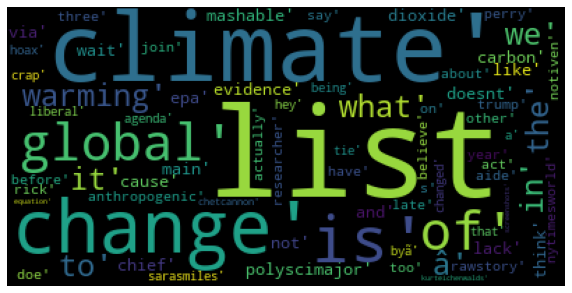

In [81]:
#most common words after preprocessing
word_cloud(train_set, 'lemma')

### Vectorization 
Here we convert the text into values.
To do this we can use:
* CountVectorizer
* Term Frequency – Inverse Document Frequency (TF – IDF)

In [72]:
#countvectorizer
vect = CountVectorizer(analyzer = lambda x: x ,
                        #ngram_range=(1,2), 
                        max_df=0.5, 
                        min_df=0.2)
#fit and transorm data 
vect.fit(train_set['lemma'])
X = vect.transform(train_set['lemma'])
    
#transform vectorized data to an array
my_array = X.toarray()
    
#transform back to a dataframe
cv_train_df = pd.DataFrame(my_array, columns=vect.get_feature_names())

print ('The shape of the new dataframe from CountVectorizer: ', cv_train_df.shape )

cv_train_df.head()

The shape of the new dataframe from CountVectorizer:  (15819, 9)


,a,global,in,is,of,the,to,warming,…
0,0,1,0,1,1,0,0,1,0
1,0,1,0,0,1,0,0,1,0
2,0,0,0,0,0,0,1,0,1
3,1,0,1,0,0,1,0,0,0
4,1,0,1,1,0,1,0,0,0


In [74]:
#TF-IDF
tf_vect = TfidfVectorizer(analyzer = lambda x: x ,
                        #ngram_range=(1,2), 
                        max_df=0.5, 
                        min_df=0.2)
                       
#fit and transorm data 
tf_vect.fit(train_set['lemma'])
X = tf_vect.transform(train_set['lemma'])
    
#transform vectorized data to an array
tf_array = X.toarray()
    
#transform back to a dataframe
tf_train_df = pd.DataFrame(tf_array, columns=tf_vect.get_feature_names())

print ('The shape of the new dataframe from TF-IDF: ', tf_train_df.shape )

tf_train_df.head()

The shape of the new dataframe from TF-IDF:  (15819, 9)


,a,global,in,is,of,the,to,warming,…
0,0.000000,0.500178,0.000000,0.489398,0.495711,0.000000,0.000000,0.514375,0.000000
1,0.000000,0.573559,0.000000,0.000000,0.568437,0.000000,0.000000,0.589838,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.658884,0.000000,0.752244
3,0.588212,0.000000,0.637569,0.000000,0.000000,0.497506,0.000000,0.000000,0.000000
4,0.503645,0.000000,0.545907,0.516593,0.000000,0.425980,0.000000,0.000000,0.000000


## Modelling 

We will build multiple models at once and determine which model is fast and good at predicting the sentiment. We will then pick the best model based on:
* The time it takes 
* The accuracy of the predictions

The models we wil test are:
* Logistic Resgression
* KNN
* SVM
* Decision Tree
* Random Forest 
* Adaboost

In [75]:
names = ['Logistic Regression', 'Nearest Neighbors', 
         'Linear SVM', 'RBF SVM',          
         'Decision Tree', 'Random Forest',  'AdaBoost']
 
classifiers = [LogisticRegression(multi_class='ovr', class_weight='balanced'), 
               KNeighborsClassifier(3),
               SVC(kernel="linear", C=0.025),
               SVC(gamma=2, C=1),
               DecisionTreeClassifier(max_depth=5),
               RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),    
               AdaBoostClassifier()
              ]

In [76]:
#define features and variables
X = cv_train_df
y = train_set['sentiment']

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [77]:
results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(names, classifiers):    
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train, y_train)
    
    print ('... predicting')
    y_pred = clf.predict(X_train)   
    y_pred_test = clf.predict(X_test)
    
    print ('... scoring')
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred, average = 'micro')
    recall    = metrics.recall_score(y_train, y_pred, average = 'micro')
    
    f1        = metrics.f1_score(y_train, y_pred, average = 'micro')    
    f1_test   = metrics.f1_score(y_test, y_pred_test, average = 'micro')    
    
    # Save the results to dictionaries
    models[name] = clf    
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)
    
    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])

    
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

print ('... All done!')

Fitting Logistic Regression model...
... predicting
... scoring
Fitting Nearest Neighbors model...
... predicting
... scoring
Fitting Linear SVM model...
... predicting
... scoring
Fitting RBF SVM model...
... predicting
... scoring
Fitting Decision Tree model...
... predicting
... scoring
Fitting Random Forest model...
... predicting
... scoring
Fitting AdaBoost model...
... predicting
... scoring
... All done!


In [63]:
results.sort_values('F1 Train', ascending=False)

,Accuracy,Precision,Recall,F1 Train,F1 Test,Train Time
Classifier,,,,,,
RBF SVM,0.601264,0.601264,0.601264,0.601264,0.578698,11.950197
AdaBoost,0.551798,0.551798,0.551798,0.551798,0.562895,0.423043
Decision Tree,0.550691,0.550691,0.550691,0.550691,0.566372,0.009495
Random Forest,0.548084,0.548084,0.548084,0.548084,0.559418,0.045057
Linear SVM,0.536863,0.536863,0.536863,0.536863,0.548673,6.727307
Nearest Neighbors,0.504702,0.504702,0.504702,0.504702,0.466182,0.198732
Logistic Regression,0.469064,0.469064,0.469064,0.469064,0.477244,0.131453


### 1. Logistic Regression

In [42]:
#define features and variables
X = new_train_df
y = train_set['sentiment']

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

logreg = LogisticRegression(multi_class='ovr', class_weight='balanced')

logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', multi_class='ovr')

In [43]:
#Generate predictions
y_pred_test = logreg.predict(X_test)

In [44]:
# Classification report
print(classification_report(y_test, y_pred_test))

import warnings
warnings.filterwarnings('ignore')

              precision    recall  f1-score   support

          -1       0.19      0.24      0.21       254
           0       0.38      0.32      0.35       457
           1       0.69      0.49      0.57      1736
           2       0.37      0.63      0.47       717

    accuracy                           0.48      3164
   macro avg       0.41      0.42      0.40      3164
weighted avg       0.53      0.48      0.49      3164



In [45]:
#confusion matrix 
confusion_matrix(y_test, y_pred_test)

array([[ 60,  48,  95,  51],
       [ 56, 146, 103, 152],
       [168, 140, 849, 579],
       [ 30,  46, 186, 455]], dtype=int64)

## Model Performance 

Apply the model to the test set with no labels

In [84]:
#load test set data
df_test = pd.read_csv('test_with_no_labels.csv')

test_set = df_test.copy()

pd.set_option('max_colwidth', None)
test_set.head()

,message,tweetid
0,Europe will now be looking to China to make sure that it is not alone in fighting climate change… https://t.co/O7T8rCgwDq,169760
1,Combine this with the polling of staffers re climate change and womens' rights and you have a fascist state. https://t.co/ifrm7eexpj,35326
2,"The scary, unimpeachable evidence that climate change is already here: https://t.co/yAedqcV9Ki #itstimetochange #climatechange @ZEROCO2_;..",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPutin got to you too Jill ! \nTrump doesn't believe in climate change at all \nThinks it's s hoax,476263
4,RT @FakeWillMoore: 'Female orgasms cause global warming!'\n-Sarcastic Republican,872928


Preprocess the data like we did with the train set. 
This means that we apply the folowing predefined functions:
* remove_noise(df, column_name)
* remove_punctuation(post)
* normalize_words(df, column_name)
* train_lemma(words, lemmatizer)
* Vecorize using CountVectorizer

In [85]:
remove_noise(test_set, 'message')
test_set['message'] = test_set['message'].apply(remove_punctuation)
normalize_words(test_set, 'message')
test_set['lemma'] = test_set['tokens'].apply(train_lemma, args=(lemmatizer, ))
test_set.head()

,message,tweetid,tokens,lemma
0,europe will now be looking to china to make sure that it is not alone in fighting climate change…,169760,"[europe, will, now, be, looking, to, china, to, make, sure, that, it, is, not, alone, in, fighting, climate, change, …]","[europe, will, now, be, looking, to, china, to, make, sure, that, it, is, not, alone, in, fighting, climate, change, …]"
1,combine this with the polling of staffers re climate change and womens rights and you have a fascist state,35326,"[combine, this, with, the, polling, of, staffers, re, climate, change, and, womens, rights, and, you, have, a, fascist, state]","[combine, this, with, the, polling, of, staffer, re, climate, change, and, woman, right, and, you, have, a, fascist, state]"
2,the scary unimpeachable evidence that climate change is already here itstimetochange climatechange zeroco,224985,"[the, scary, unimpeachable, evidence, that, climate, change, is, already, here, itstimetochange, climatechange, zeroco]","[the, scary, unimpeachable, evidence, that, climate, change, is, already, here, itstimetochange, climatechange, zeroco]"
3,karoli morgfair osborneink dailykos \nputin got to you too jill \ntrump doesnt believe in climate change at all \nthinks its s hoax,476263,"[karoli, morgfair, osborneink, dailykos, putin, got, to, you, too, jill, trump, doesnt, believe, in, climate, change, at, all, thinks, its, s, hoax]","[karoli, morgfair, osborneink, dailykos, putin, got, to, you, too, jill, trump, doesnt, believe, in, climate, change, at, all, think, it, s, hoax]"
4,fakewillmoore female orgasms cause global warming\nsarcastic republican,872928,"[fakewillmoore, female, orgasms, cause, global, warming, sarcastic, republican]","[fakewillmoore, female, orgasm, cause, global, warming, sarcastic, republican]"


### Vectorize

In [86]:
#countvectorizer on test set
vect = CountVectorizer(analyzer = lambda x: x ,
                        #ngram_range=(1,2), 
                        max_df=0.5, 
                        min_df=0.2)
#fit and transorm data 
vect.fit(test_set['lemma'])
X = vect.transform(test_set['lemma'])
    
#transform vectorized data to an array
my_array = X.toarray()
    
#transform back to a dataframe
new_test_df = pd.DataFrame(my_array, columns=vect.get_feature_names())

new_test_df.head()

,a,global,in,is,of,the,to,warming,…
0,0,0,1,1,0,0,2,0,1
1,1,0,0,0,1,1,0,0,0
2,0,0,0,1,0,1,0,0,0
3,0,0,1,0,0,0,1,0,0
4,0,1,0,0,0,0,0,1,0


Confirm that our generated test dataset has the same columns as the train set (9 columns)

In [90]:
new_test_df.shape

(10546, 9)

In [100]:
#generate predictions using our logistic regression model
X = new_test_df
pred_sentiment = logreg.predict(X)

#add the predicted sentiments to our test set with no labels
test_set['sentiment'] = pred_sentiment

#extract a dataframe for submission
sub_df = test_set[['tweetid','sentiment']]

#save submission dataframe to csv
sub_df.to_csv('logisticregression.csv', header=True, index=False)